# Import Statements

In [1]:
!pip install emoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 421.5/421.5 kB 7.5 MB/s eta 0:00:00


In [2]:
import pandas as pd # Imported to enable the use of datastructures like dataframe
import matplotlib.pyplot as plt # Imported to visusalise data
import seaborn as sns # Imported to visualise data
import numpy as np # Imported for calculations
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer # Imported to convert raw documents into a matrix of tf idf features
from sklearn.linear_model import LogisticRegression # Imported to enable the use of logistic regression to classify text
from sklearn.model_selection import train_test_split # Imported to enable the user to split the data into train, test samples
from sklearn.metrics import classification_report, accuracy_score # Imported to calculate the accuracy and also print the classification report
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score # for report generation
from sklearn.feature_extraction.text import CountVectorizer
import emoji #Imported to check how many sentences have emojis

# imports for word cloud
from collections import Counter
from wordcloud import WordCloud


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importing the dataset

In [4]:
path='/content/drive/MyDrive/Datasets/malayalam.tsv'
df = pd.read_csv(path, sep='\t')
print(df)

             category                                               text
0      unknown_state    Ichayan fans pinne mmade ettan fansm ivde oru...
1      not-malayalam              Tovi 🥰 Best Wishes From #Kunjikka Fans
2      unknown_state    Urutty koll .nallavanaaya unniyaya saiju kuru...
3      not-malayalam    Pls support me pls       My channel subscribe...
4           Positive      Kalki super hit akum enn Bonny parayan paranju
...               ...                                                ...
6734        Positive      Jayettanu eduthal pongayha role aan...next idi
6735        Positive                 This looks like... Thrishur pooram.
6736        Negative    Mammukka verum vishayam engneru eth enthonn c...
6737  Mixed_feelings    Pulikku pakaram patti odande vere mattam onnu...
6738        Positive    Ithin dislike addikunavar lokka tholvikallayi...

[6739 rows x 2 columns]


# Exploring the dataset

In [5]:
print(df.shape)
df.head()

(6739, 2)


,category,text
0,unknown_state,Ichayan fans pinne mmade ettan fansm ivde oru...
1,not-malayalam,Tovi 🥰 Best Wishes From #Kunjikka Fans
2,unknown_state,Urutty koll .nallavanaaya unniyaya saiju kuru...
3,not-malayalam,Pls support me pls My channel subscribe...
4,Positive,Kalki super hit akum enn Bonny parayan paranju


## Descrpancies Found

In [6]:
# Database is imbalanced, nothing has been done to rectify this.

value_counts = df['category'].value_counts()
print(value_counts)

Positive           2811
unknown_state      1903
not-malayalam       884
Negative            738
Mixed_feelings      403
Name: category, dtype: int64


In [7]:
# Pre processing is not done as mentioned in the paper.


# We preprocessed the comments by removing the emoji’s,
# and sentence length longer than 15 or less than 5 words since
# sentence more than 15 words will be difficult for annotators.
# After cleaning, we got 6,738 sentences for Malayalam-English
# code-mixed post comments.

# Function to count words in a sentence
def count_words(sentence):
    return len(sentence.split())

# Apply the function and filter the DataFrame
df_wordsGreater15 = df[df['text'].apply(lambda x: count_words(x) > 15)]
df_wordsLess5 = df[df['text'].apply(lambda x: count_words(x) < 5)]


# Function to check if a sentence contains any emoji
def contains_emoji(sentence):
    for character in sentence:
        if emoji.is_emoji(character):
            return True
    return False

# Apply the function and count sentences with emojis
df_emojis = df[df['text'].apply(contains_emoji)]

print(df_wordsGreater15.shape) #236 sentences have more than 15 words
print(df_wordsLess5.shape) #346 sentences have less than 5 words
print(df_emojis.shape) #309 sentences have emojis in them


(236, 2)
(346, 2)
(309, 2)


In [8]:
# Renaming the classes for convenience

# Removing any leading/trailing spaces
df['category'] = df['category'].str.strip()

# Replacing 'unknown_state' with 'Irrelevant'
df['category'] = df['category'].replace({'unknown_state': 'Neutral'})
df['category'] = df['category'].replace({'not-malayalam': 'Not-Malayalam'})

# Viewing the number of items in each class after replacement
print(df['category'].value_counts())  # Used to view the number of items in each class.

## There is a significant imbalance in the classes in this dataset

Positive          2811
Neutral           1903
Not-Malayalam      884
Negative           738
Mixed_feelings     403
Name: category, dtype: int64


In [9]:
# Creating dataframes for all categories for later use

df_positive_words = df[df['category']=='Positive']
df_negative_words = df[df['category']=='Negative']
df_mixed_feeling_words = df[df['category']=='Mixed_feelings']
df_neutral_words = df[df['category']=='Neutral']
df_not_malayalam_words = df[df['category']=='Not-Malayalam']

print(df_positive_words.shape)
print(df_negative_words.shape)
print(df_mixed_feeling_words.shape)
print(df_neutral_words.shape)
print(df_not_malayalam_words.shape)

(2811, 2)
(738, 2)
(403, 2)
(1903, 2)
(884, 2)


In [10]:
# Count number of sentences

# # Function to count sentences in a text
# def count_sentences(text):
#     return len(sent_tokenize(text))

# # Apply the function to each row in the DataFrame's column and sum the results
# df['sentence_count'] = df['text'].apply(count_sentences)
# total_sentences = df['sentence_count'].sum()

# print("Total sentences:", total_sentences)


# # # Function to calculate average sentence length in words for a given text
# # def avg_sentence_length_nltk(text):
#     sentences = sent_tokenize(text)
#     if len(sentences) == 0:
#         return 0
#     total_length = sum(len(word_tokenize(sentence)) for sentence in sentences)
#     return total_length / len(sentences)

# # Apply the function to each row in the DataFrame's 'text' column
# df['avg_sentence_length'] = df['text'].apply(avg_sentence_length_nltk)

# # Calculate the overall average sentence length across all texts
# overall_avg_length = df['avg_sentence_length'].mean()


# print(f"Overall average sentence length: {overall_avg_length} words")

In [11]:
def analyze_text(text):
    # Tokenizes the text into sentences
    sentences = sent_tokenize(text)
    sentence_count = len(sentences)

    # Tokenizes the text into words
    words = word_tokenize(text)
    word_count = len(words)

    # Computes the vocabulary size
    vocabulary_size = len(set(words))

    # Calculates average sentence length in terms of words
    avg_sentence_length = word_count / sentence_count if sentence_count > 0 else 0

    return sentence_count, word_count, vocabulary_size, avg_sentence_length

# Apply the analysis function to each text entry in the DataFrame
analysis_results = df['text'].apply(lambda x: analyze_text(x))

# Unpack the results into separate columns
df['sentence_count'], df['word_count'], df['vocabulary_size'], df['avg_sentence_length'] = zip(*analysis_results)

# To find the total number of tokens, you can sum up the word counts
total_tokens = df['word_count'].sum()

# Display the overall analysis results and the updated DataFrame
print(f"Total number of tokens: {total_tokens}")
print(df.head())  # Adjust according to how you wish to view the results


Total number of tokens: 61022
        category                                               text  \
0        Neutral   Ichayan fans pinne mmade ettan fansm ivde oru...   
1  Not-Malayalam             Tovi 🥰 Best Wishes From #Kunjikka Fans   
2        Neutral   Urutty koll .nallavanaaya unniyaya saiju kuru...   
3  Not-Malayalam   Pls support me pls       My channel subscribe...   
4       Positive     Kalki super hit akum enn Bonny parayan paranju   

   sentence_count  word_count  vocabulary_size  avg_sentence_length  
0               1          13               13                 13.0  
1               1           8                8                  8.0  
2               1          11               11                 11.0  
3               1           9                7                  9.0  
4               1           8                8                  8.0  


In [12]:
pip install spacy
python -m spacy download en_core_web_sm

import pandas as pd
import spacy

# Load the spaCy model
nlp = spacy.load("en_core_web_sm")

# Define a function to analyze the text
def analyze_text_spacy(text):
    doc = nlp(text)

    # Sentence count
    sentence_count = len(list(doc.sents))

    # Word count (excluding punctuations)
    word_count = len([token for token in doc if not token.is_punct])

    # Vocabulary size (unique words, excluding punctuations)
    vocabulary_size = len(set([token.text.lower() for token in doc if not token.is_punct]))

    # Average sentence length
    avg_sentence_length = word_count / sentence_count if sentence_count > 0 else 0

    return sentence_count, word_count, vocabulary_size, avg_sentence_length

# Apply the analysis function to each row in the 'text' column
df[['sentence_count', 'word_count', 'vocabulary_size', 'avg_sentence_length']] = df['text'].apply(
    lambda x: pd.Series(analyze_text_spacy(x))
)

# Calculate the total number of tokens (sum of word counts)
total_tokens = df['word_count'].sum()

# Display the overall analysis results and the updated DataFrame
print(f"Total number of tokens: {total_tokens}")
print(df.head())  # Adjust according to how you wish to view the results



SyntaxError: invalid syntax (<ipython-input-12-de6ae274d072>, line 1)

# Visualising the data

In [ ]:

# Calculate sentence length in terms of words and characters
df['word_count'] = df['text'].apply(lambda x: len(word_tokenize(x)))



df['char_count'] = df['text'].apply(lambda x: len(str(x)))

# Summary statistics for sentence lengths
sentence_length_stats = df[['word_count', 'char_count']].describe()

print(sentence_length_stats)

In [ ]:
# Category distribution
plt.figure(figsize=(10,4))
sns.countplot(data=df, x='category', palette="viridis")
plt.title('Category/Sentiment Distribution')
plt.xticks(rotation=0)
plt.show()

In [ ]:
# Sentence length distribution in words
plt.figure(figsize=(10,4))
sns.histplot(data=df, x='word_count', bins=30, color='skyblue')
plt.title('Sentence Length Distribution (in words)')
plt.xlabel('Sentence Length (words)')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Sentence length distribution in characters
plt.figure(figsize=(10,4))
sns.histplot(data=df, x='char_count', bins=30, color='skyblue')
plt.title('Sentence Length Distribution (in characters)')
plt.xlabel('Sentence Length (Characters)')
plt.ylabel('Frequency')
plt.show()

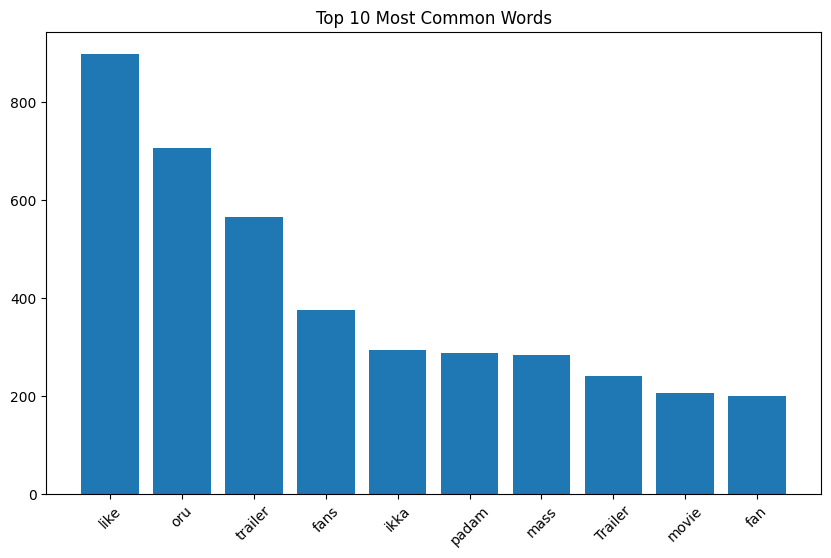

In [13]:
# Word Frequency Analysis
all_words = ' '.join(df['text']).split()
positive_words = ' '.join(df_positive_words['text']).split()
negative_words = ' '.join(df_negative_words['text']).split()
mixed_feeling_words= ' '.join(df_mixed_feeling_words['text']).split()
neutral_words = ' '.join(df_neutral_words['text']).split()
not_malayalam_words  = ' '.join(df_not_malayalam_words['text']).split()


word_frequencies = Counter(all_words)
most_common_words = word_frequencies.most_common(10)

# Plotting the most common words
plt.figure(figsize=(10, 6))
plt.bar(*zip(*most_common_words))
plt.title('Top 10 Most Common Words')
plt.xticks(rotation=45)
plt.show()

<ipython-input-14-f096a5528713>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='category', y='word_count', data=df, estimator=np.mean, palette='viridis')


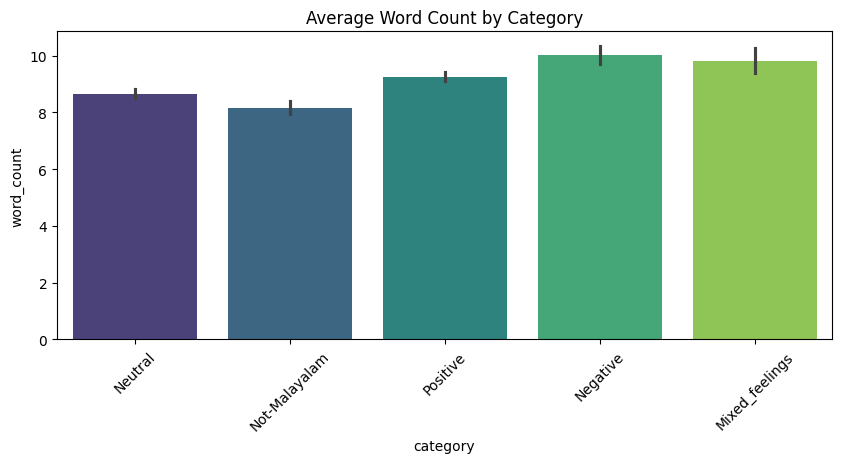

In [14]:
# Category-wise Word Counts

plt.figure(figsize=(10, 4))
sns.barplot(x='category', y='word_count', data=df, estimator=np.mean, palette='viridis')
plt.title('Average Word Count by Category')
plt.xticks(rotation=45)
plt.show()

In [15]:
#  Category-wise Character Counts

plt.figure(figsize=(10, 4))
sns.barplot(x='category', y='char_count', data=df, estimator=np.mean,palette='viridis')
plt.title('Average Character Count by Category')
plt.xticks(rotation=45)
plt.show()

ValueError: Could not interpret value `char_count` for `y`. An entry with this name does not appear in `data`.

<Figure size 1000x400 with 0 Axes>

In [ ]:
# Word Cloud For All Words

wordcloud = WordCloud(width = 800, height = 400, background_color ='white').generate(' '.join(all_words))
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
# Word Cloud For Positive Words

wordcloud = WordCloud(width = 800, height = 400, background_color ='white').generate(' '.join(positive_words))
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
# Word Cloud For Negative Words

wordcloud = WordCloud(width = 800, height = 400, background_color ='white').generate(' '.join(negative_words))
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:


def plot_ngram_distribution(texts, n=None):
    """Plot the distribution of n-grams."""
    vect = CountVectorizer(ngram_range=(n, n)).fit(texts)
    bag_of_words = vect.transform(texts)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vect.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    top_n_words = words_freq[:10]

    plt.figure(figsize=(10, 6))
    plt.bar(*zip(*top_n_words))
    plt.title(f'Top 10 {n}-grams')
    plt.xticks(rotation=45)
    plt.show()

# Example usage for bigrams
plot_ngram_distribution(df['text'], n=2)


In [ ]:
# import nltk
# from collections import Counter

# # Download necessary NLTK data
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')

# # POS Tagging
# words = nltk.word_tokenize(' '.join(df['text']))
# pos_tags = nltk.pos_tag(words)
# pos_counts = Counter(tag for word, tag in pos_tags)

# # Plotting
# plt.figure(figsize=(10, 6))
# plt.bar(pos_counts.keys(), pos_counts.values())
# plt.title('POS Tagging Distribution')
# plt.xticks(rotation=45)
# plt.show()


### Next we would need to map these classes into numbers for the machine learning model

In [16]:
df['label_num'] = df.category.map({
    'Positive':0,
    'Negative':1,
    'Mixed_feelings':2,
    'Neutral':3,
    'Not-Malayalam':4
})

df.head

<bound method NDFrame.head of             category                                               text  \
0            Neutral   Ichayan fans pinne mmade ettan fansm ivde oru...   
1      Not-Malayalam             Tovi 🥰 Best Wishes From #Kunjikka Fans   
2            Neutral   Urutty koll .nallavanaaya unniyaya saiju kuru...   
3      Not-Malayalam   Pls support me pls       My channel subscribe...   
4           Positive     Kalki super hit akum enn Bonny parayan paranju   
...              ...                                                ...   
6734        Positive     Jayettanu eduthal pongayha role aan...next idi   
6735        Positive                This looks like... Thrishur pooram.   
6736        Negative   Mammukka verum vishayam engneru eth enthonn c...   
6737  Mixed_feelings   Pulikku pakaram patti odande vere mattam onnu...   
6738        Positive   Ithin dislike addikunavar lokka tholvikallayi...   

      sentence_count  word_count  vocabulary_size  avg_sentence_lengt

# Preparing the Training, and Test Dataset

In [17]:
# Splitting the dataset

# Training Set: 70%
# Test Set: 20%
# Validation Set: 10%

X_train, X_temp, y_train, y_temp = train_test_split(
    df.text,
    df.category,
    test_size=.3, # 30% of samples will be present in temporary dataset
    random_state=42)

X_test, X_val, y_test, y_val = train_test_split(
    X_temp,
    y_temp,
    test_size=1/3, # 10% -> X_val and rest 20% -> X_test
    random_state=42)

# print(X_train,y_train)

# Vectorization using TF-IDF
v = TfidfVectorizer()
X_train_tfidf = v.fit_transform(X_train)
X_test_tfidf = v.transform(X_test)

# print(X_test_tfidf)
print(X_train_tfidf.shape)
print(X_test_tfidf.shape)
print(X_val.shape)

(4717, 12599)
(1348, 12599)
(674,)


# Implementing the Logistic Regression Model

In [18]:
# Logistic Regression model
log_reg = LogisticRegression()
log_reg.fit(X_train_tfidf, y_train)

# Predictions and evaluation
predictions = log_reg.predict(X_test_tfidf)
print("Accuracy:", accuracy_score(y_test, predictions))
print(classification_report(y_test, predictions))

Accuracy: 0.6683976261127597
                precision    recall  f1-score   support

Mixed_feelings       0.69      0.11      0.19        80
      Negative       0.85      0.45      0.59       142
       Neutral       0.60      0.66      0.63       361
 Not-Malayalam       0.75      0.56      0.64       163
      Positive       0.67      0.83      0.74       602

      accuracy                           0.67      1348
     macro avg       0.71      0.52      0.56      1348
  weighted avg       0.68      0.67      0.65      1348



In [30]:
# Your sentence
sentence = "oola padam"
preprocessed_sentence = sentence.lower()  # Preprocess the sentence


# Now, transform the preprocessed sentence into a vector
vectorized_sentence = v.transform([preprocessed_sentence])

# Since vectorizer is now fitted, this should work without error
print(vectorized_sentence)

# Predict using your logistic regression model
# Ensure your logistic regression model is trained and compatible with the vector shape
prediction = log_reg.predict(vectorized_sentence)

print("Prediction:", prediction)

  (0, 8345)	0.4564854008832707
  (0, 8138)	0.8897309024533426
Prediction: ['Negative']


Accuracy: 0.6683976261127597

Classification Report:
                 precision    recall  f1-score   support

Mixed_feelings       0.69      0.11      0.19        80
      Negative       0.85      0.45      0.59       142
       Neutral       0.60      0.66      0.63       361
 Not-Malayalam       0.75      0.56      0.64       163
      Positive       0.67      0.83      0.74       602

      accuracy                           0.67      1348
     macro avg       0.71      0.52      0.56      1348
  weighted avg       0.68      0.67      0.65      1348



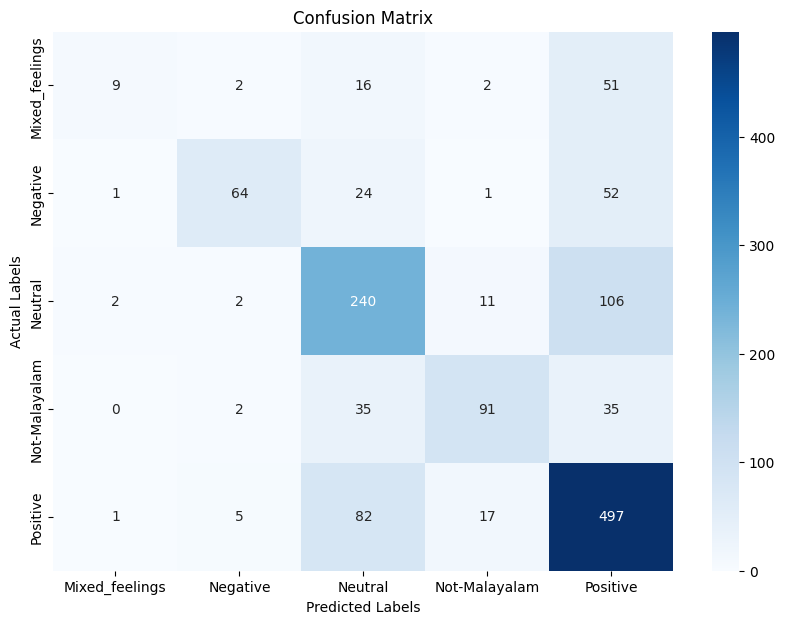

In [ ]:
# Assuming predictions have been made as shown earlier
print("Accuracy:", accuracy_score(y_test, predictions))
print("\nClassification Report:\n", classification_report(y_test, predictions))

# Generate the confusion matrix
cm = confusion_matrix(y_test, predictions)
class_names = np.unique(y_test)  # Assuming y_test contains your actual labels

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()